## Análise das Resenhas de Apps de Bancos

### Parte II - Tratamento dos Dados e Machine Learning

### 1. Importação das bibliotecas necessárias

In [1]:
# para importar e manipular dados
import numpy  as np
import pandas as pd

# para expressão regular
import re

# para remover pontuações
import string

# para nlp
import spacy

# para manipular emoji/emoticon
import emot
from emot.emo_unicode import UNICODE_EMO

# para vetorizar
from sklearn.feature_extraction.text import TfidfVectorizer

# para gerar dados sintéticos e balancear a variável a ser predita
from imblearn.over_sampling import SMOTE

# para dispor os dados na mesma escala
from sklearn.preprocessing import MinMaxScaler

# modelo de machine learning
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble        import RandomForestClassifier
from sklearn.naive_bayes     import MultinomialNB
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression

# para avaliar o modelo
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import scikitplot as skplt

# para salvar artefatos
import pickle

# cria o objeto de pré processamento spacy
pln = spacy.load('pt')

# exibir todas as colunas do dataframe
pd.set_option('display.max_columns', None)

### 2. Importação e tratamento inicial dos dados
#### 2.1. Importação dos dados
São dois conjuntos de dados, a primeira planilha é o conjunto de dados para treinamento do modelo de Machine Learning e a segunda é conjunto de dados para avaliação do modelo.

In [2]:
# importação da primeira planilha - para treinamento
resenhas_treino = pd.read_excel('../data/Satisfação com App.xlsx')
resenhas_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8702 entries, 0 to 8701
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Instituição               8702 non-null   object        
 1   Comentario                8698 non-null   object        
 2   Data                      8702 non-null   datetime64[ns]
 3   Classificação             8702 non-null   int64         
 4   Elogio quanto ao app      8702 non-null   object        
 5   Reclamação quanto ao app  8702 non-null   object        
 6   Elogio a Instituição      8702 non-null   object        
 7   Reclamação a Instituição  8702 non-null   object        
 8   Não Classificável         8702 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 612.0+ KB


In [3]:
# importação da segunda planilha - para validação
resenhas_validacao = pd.read_excel('../data/Satisfação com App.xlsx', sheet_name=1)
resenhas_validacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Instituição               1375 non-null   object        
 1   Comentario                1375 non-null   object        
 2   Data                      1375 non-null   datetime64[ns]
 3   Classificação             1375 non-null   int64         
 4   Elogio quanto ao app      1375 non-null   object        
 5   Reclamação quanto ao app  1375 non-null   object        
 6   Elogio a Instituição      1375 non-null   object        
 7   Reclamação a Instituição  1375 non-null   object        
 8   Não Classificável         1375 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 96.8+ KB


#### 2.2. Tratamento inicial dos dados

In [4]:
# alterar os nomes das variáveis eliminando os espaços vazios
col_names = [col.replace(' ', '_') for col in resenhas_treino.columns]
resenhas_treino.columns        = col_names
resenhas_validacao.columns = col_names

In [5]:
# excluir os regisros com valores ausentes
resenhas_treino.dropna(inplace=True)
resenhas_validacao.dropna(inplace=True)

In [6]:
# alterar as variáveis relativas aos sentimentos atribuídos às resenhas dos usuários em maiúsculas
ls_cols_sentimentos = [col for col in resenhas_treino.columns if 'Elogio' in col or 'Reclamação' in col or 'Classificável' in col]
resenhas_treino[ls_cols_sentimentos]    = resenhas_treino[ls_cols_sentimentos].apply(lambda x: x.str.upper())
resenhas_validacao[ls_cols_sentimentos] = resenhas_validacao[ls_cols_sentimentos].apply(lambda x: x.str.upper())

In [7]:
# unificar a ausência do til
for var in ls_cols_sentimentos:
    resenhas_treino[var]    = resenhas_treino[var].map({'NÃO': 'NAO', 'SIM': 'SIM'})
    resenhas_validacao[var] = resenhas_validacao[var].map({'NÃO': 'NAO', 'SIM': 'SIM'})

In [8]:
# criar coluna 5_estrelas que recebe 1 quando a classificação for 5 e 0 para demais valores
resenhas_treino['5_estrelas'] = 0
resenhas_validacao['5_estrelas'] = 0

def cinco_estrela(df):
    if df['Classificação'] == 5:
        return 1
    else:
        return 0

resenhas_treino['5_estrelas'] = resenhas_treino.apply(cinco_estrela, axis=1)
resenhas_validacao['5_estrelas'] = resenhas_validacao.apply(cinco_estrela, axis=1)

In [9]:
# ... e checar a proporção
resenhas_treino['5_estrelas'].value_counts() / len(resenhas_treino) * 100

1    68.487009
0    31.512991
Name: 5_estrelas, dtype: float64

In [10]:
# amostra dos dados:
resenhas_treino.tail()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas
8697,Caixa Econômica Federal,Muito bom,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1
8698,Caixa Econômica Federal,Top,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1
8699,Caixa Econômica Federal,A facilidade de resolver minhas movimentação b...,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1
8700,Caixa Econômica Federal,"Péssimo ,vou desinstalar",2020-08-24,1,NAO,SIM,NAO,NAO,NAO,0
8701,Caixa Econômica Federal,Boa,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1


In [11]:
# amostra dos dados:
resenhas_validacao.tail()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas
1370,Caixa Econômica Federal,Ótimo,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1
1371,Caixa Econômica Federal,Ótima,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1
1372,Caixa Econômica Federal,Ta melhorando,2020-08-24,4,SIM,NAO,NAO,NAO,NAO,0
1373,Caixa Econômica Federal,Deveria se mais fácil pra pagar contas,2020-08-24,2,NAO,SIM,NAO,NAO,NAO,0
1374,Caixa Econômica Federal,Muito boa,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1


### 3. Tratamento dos dados

#### 3.1. Tratando emojis e emoticons
Objetivo é converter o sentimento expresso pelo emoji ou emoticon pelas palavras `ótimo` ou `ruim`. O que não for possível interpretar pelo emoji ou emoticon será convertido para texto em inglês.

In [12]:
# criar lista de comentários
lista_comentarios = resenhas_treino['Comentario'].tolist()

In [13]:
# criar função para armazenar lista de emojis e emoticons
# a depender do texto, pode ser retornada uma lista, o que é tratado a seguir
emojis = []
emotis = []

def localiza_emoji_emoti(texto):  
    emoji = emot.emoji(texto)
    emoti = emot.emoticons(texto)
    
    if emoji['flag'] == True:
        emojis.append(emoji['value'])
        
    try:
        if emoti['flag'] == True:
            emotis.append(emoti['value'])
    except:
        emotis.append('nada')

In [14]:
# aplicando a função na lista de comentários
for txt in lista_comentarios:
    localiza_emoji_emoti(txt)

In [15]:
# removendo duplicidade dos emojis e emoticos
lista_emojis = []
lista_emotis = []

for linha in emojis:
    for emoji in linha:
        if emoji not in lista_emojis:
            lista_emojis.append(emoji)
            
for linha in emotis:
    for emoti in linha:
        if emoti != 'nada' and emoti not in lista_emotis:
            lista_emotis.append(emoti)
            
len(lista_emojis), len(lista_emotis)

(105, 8)

In [16]:
# visualizar os primeiros emojis:
lista_emojis[0:6]

['🏦', '😇', '💜', '😍', '♥', '👊']

In [17]:
# visualizar os primeiros emoticons:
lista_emotis[0:6]

[':(', 'n', 'a', 'd', 'XP', ';)']

In [18]:
# na lista de emoticons foi capturada parte da string "nada", estes valores podem ser removidos
lista_emotis.remove('n')
lista_emotis.remove('d')
lista_emotis.remove('a')

In [19]:
# criar dois dicionários com as interpretações, um para emojis outro para emoticons
dict_emojis = {
    'exclamation_question_mark': 'ruim',
    'person_pouting': 'ruim',
    'kiss_mark': 'ótimo',
    'upside-down_face': 'ótimo',
    'smiling_face_with_open_mouth_&_smiling_eyes': 'ótimo',
    'love_letter': 'ótimo',
    'rose': 'ótimo',
    'angry_face_with_horns': 'ruim',
    'yellow_heart': 'ótimo',
    'blue_heart': 'ótimo',
    'green_heart': 'ótimo',
    'relieved_face': 'ótimo',
    'trophy': 'ótimo',
    'expressionless_face': 'ruim',
    'slightly_smiling_face': 'ótimo',
    'nauseated_face': 'ruim',
    'face_with_stuck-out_tongue_&_winking_eye': 'ótimo',
    'OK_hand': 'ótimo',
    'neutral_face': 'ruim',
    'person_shrugging': 'ruim',
    'weary_face': 'ruim',
    'heart_with_arrow': 'ótimo',
    'grimacing_face': 'ruim',
    'sleepy_face': 'ruim',
    'pig_face': 'ruim',
    'thinking_face': 'ruim',
    'loudly_crying_face': 'ruim',
    'blossom': 'ótimo',
    'face_with_cold_sweat': 'ruim',
    'crying_cat_face': 'ruim',
    'unamused_face': 'ruim',
    'disappointed_but_relieved_face': 'ruim',
    'smiling_face': 'ótimo',
    'face_screaming_in_fear': 'ruim',
    'face_with_steam_from_nose': 'ruim',
    'broken_heart': 'ruim',
    'see-no-evil_monkey': 'ruim',
    'two_hearts': 'ótimo',
    'growing_heart': 'ótimo',
    'slightly_frowning_face': 'ruim',
    'crying_face': 'ruim',
    'dizzy': 'ruim',
    'smiling_face_with_open_mouth_&_closed_eyes': 'ótimo',
    'victory_hand': 'ótimo',
    'face_with_rolling_eyes': 'ruim',
    'revolving_hearts': 'ótimo',
    'smiling_face_with_open_mouth': 'ótimo',
    'rolling_on_the_floor_laughing': 'ótimo',
    'pensive_face': 'ruim',
    'dizzy_face': 'ruim',
    'angry_face': 'ruim',
    'confused_face': 'ruim',
    'smiling_face_with_open_mouth_&_cold_sweat': 'ótimo',
    'smirking_face': 'ótimo',
    'smiling_face_with_sunglasses': 'ótimo',
    'face_with_tears_of_joy': 'ótimo',
    'white_medium_star': 'ótimo',
    'thumbs_down': 'ruim',
    'red_heart': 'ótimo',
    'clapping_hands': 'ótimo',
    'smiling_face_with_halo': 'ótimo',
    'purple_heart': 'ótimo',
    'smiling_face_with_heart-eyes': 'ótimo',
    'heart_suit': 'ótimo',
    'hugging_face': 'ótimo',
    'glowing_star': 'ótimo',
    'smiling_face_with_smiling_eyes': 'ótimo',
    'grinning_face_with_smiling_eyes': 'ótimo',
    'thumbs_up': 'ótimo',
    'face_blowing_a_kiss': 'ótimo',
    'winking_face': 'ótimo'
}

dict_emotis = {
    'Wink or smirk': 'ótimo',
    'Happy face or smiley': 'ótimo',
    'Tongue sticking out, cheeky, playful or blowing a raspberry': 'ótimo',
    'Frown, sad, andry or pouting': 'ruim',
    'Skeptical, annoyed, undecided, uneasy or hesitant': 'ruim'
}

len(dict_emojis), len(dict_emotis)
# dos 105 emojis, 71 foram traduzidos. Os emoticons foram todos traduzidos

(71, 5)

In [20]:
# transformar emoji/emoticon para seu significado literal
# fonte: https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d#:~:text=Text%20preprocessing%20is%20an%20important,learning%20algorithms%20can%20perform%20better.

def traduzir_emoti_emoji(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, UNICODE_EMO[emot])
        text = text.replace(':', ' ')

    lista = text.split(' ')
    for x in range(len(lista)):
        chave = lista[x]
        if chave in dict_emojis:
            lista[x] = dict_emojis[chave]
        if chave in dict_emotis:
            lista[x] = dict_emotis[chave]
            
    texto = ' '
    texto = (texto.join(lista)) 
    texto = texto.strip()
            
    return texto

#### 3.2. Tratamentos finais

Criar lista de comentários (resenhas) que possuem somente uma palavra. Esta lista servirá de base para que, ao se limpar os dados eliminando as stop words, não sejam gerados valores nulos.

In [21]:
ls_resenha_uma_palavra = list(set(resenhas_treino[resenhas_treino['Comentario'].fillna(' ').str.split().str.len() == 1]['Comentario'].str.lower().values))
len(ls_resenha_uma_palavra)

324

In [22]:
# importar stop words em português do Spacy
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words = STOP_WORDS
len(stop_words)

413

In [23]:
# lista final de stop words
ls_stop_words = [word for word in stop_words if word not in ls_resenha_uma_palavra]
len(ls_stop_words)

409

Funções para pré-tratamento dos dados

In [24]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
# função final de préprocessamento

def preprocessamento(texto):
    # Letras minúsculas
    texto = str(texto).lower()
    
    # converter emoji/emoticon para texto
    texto = traduzir_emoti_emoji(texto)

    # Espaços em branco
    texto = re.sub(r" +", ' ', texto)

    # Lematização
    documento = pln(texto)

    lista = []
    for token in documento:
        lista.append(token.lemma_)
  
    # Stop words, pontuações e espaços em excesso (função strip)
    lista = [palavra for palavra in lista if palavra not in ls_stop_words and palavra not in pontuacoes]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()]).strip()

    return lista

In [26]:
# aplicando pré processamento e armazenando em nova coluna
resenhas_treino['coment_processado']    = resenhas_treino['Comentario'].apply(preprocessamento)
resenhas_validacao['coment_processado'] = resenhas_validacao['Comentario'].apply(preprocessamento)

In [27]:
resenhas_treino.head()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas,coment_processado
0,Banco do Brasil,Muito bom ajuda muito,2019-07-21,5,SIM,NAO,NAO,NAO,NAO,1,bom ajudar
1,Banco do Brasil,excelente,2019-07-21,5,SIM,NAO,NAO,NAO,NAO,1,excelente
2,Banco do Brasil,Bom,2019-07-21,5,SIM,NAO,NAO,NAO,NAO,1,bom
3,Banco do Brasil,aplicativo muito top,2019-07-21,5,SIM,NAO,NAO,NAO,NAO,1,aplicativo top
4,Banco do Brasil,Fácil e prático,2019-07-21,5,SIM,NAO,NAO,NAO,NAO,1,fácil e prático


In [28]:
resenhas_treino.tail()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas,coment_processado
8697,Caixa Econômica Federal,Muito bom,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,bom
8698,Caixa Econômica Federal,Top,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,top
8699,Caixa Econômica Federal,A facilidade de resolver minhas movimentação b...,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,o facilidade resolver movimentação bancário gr...
8700,Caixa Econômica Federal,"Péssimo ,vou desinstalar",2020-08-24,1,NAO,SIM,NAO,NAO,NAO,0,mau desinstalar
8701,Caixa Econômica Federal,Boa,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,bom


In [29]:
resenhas_validacao.head()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas,coment_processado
0,Banco do Brasil,Muito bom o App. Sugiro uma melhoria na aba tr...,2019-08-11,4,SIM,SIM,NAO,NAO,NAO,0,bom o app sugerir umar melhoria o abar transfe...
1,Banco do Brasil,excelente,2019-08-11,5,SIM,NAO,NAO,NAO,NAO,1,excelente
2,Banco do Brasil,Muito eficiente e rápido,2019-08-11,5,SIM,NAO,NAO,NAO,NAO,1,eficiente e rápido
3,Banco do Brasil,muito útil no dia a dia!!!!!,2019-08-11,4,SIM,NAO,NAO,NAO,NAO,0,útil o dia o dia
4,Banco do Brasil,"estou gostando muito, pois é bem prático e fác...",2019-08-11,5,SIM,NAO,NAO,NAO,NAO,1,gostar prático e fácil satisfazer necessidade


In [30]:
resenhas_validacao.tail()

,Instituição,Comentario,Data,Classificação,Elogio_quanto_ao_app,Reclamação_quanto_ao_app,Elogio_a_Instituição,Reclamação_a_Instituição,Não_Classificável,5_estrelas,coment_processado
1370,Caixa Econômica Federal,Ótimo,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,ótimo
1371,Caixa Econômica Federal,Ótima,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,ótima
1372,Caixa Econômica Federal,Ta melhorando,2020-08-24,4,SIM,NAO,NAO,NAO,NAO,0,ta melhorar
1373,Caixa Econômica Federal,Deveria se mais fácil pra pagar contas,2020-08-24,2,NAO,SIM,NAO,NAO,NAO,0,dever fácil pra pagar contar
1374,Caixa Econômica Federal,Muito boa,2020-08-24,5,SIM,NAO,NAO,NAO,NAO,1,bom


#### 3.2. Feature Engineering
Processar texto com Spacy

In [31]:
# transaformar a lista em objeto tipo string
ls_resenhas = resenhas_treino['coment_processado'].tolist()
texto = ' '.join(ls_resenhas)
type(texto)

str

In [32]:
# carregar o modelo Spacy em português
nlp = spacy.load('pt')
# ... e processar o texto
doc = nlp(texto)

Funções para criar novas variáveis

In [33]:
def qtde_palavras(texto):
    texto = str(texto)
    palavras = texto.split()
    return len(palavras)

def qtde_maiusculas(texto):
    texto = str(texto)
    quantidade = 0
    for c in texto:
        if c.isupper():
            quantidade += 1
    return quantidade

def comprimento(texto):
    texto = str(texto)
    return len(texto)

def qtde_exclamacoes(texto):
    texto = str(texto)
    quantidade = 0
    for x in range(len(texto)):
        if '!' in texto[x]:
            quantidade += 1
    return quantidade

def qtde_interrogacoes(texto):
    texto = str(texto)
    quantidade = 0
    for x in range(len(texto)):
        if '?' in texto[x]:
            quantidade += 1
    return quantidade

def qtde_pontuacoes(texto):
    texto = str(texto)
    quantidade = 0
    for x in range(len(texto)):
        if '.' in texto[x] or ',' in texto[x] or ';' in texto[x] or ':' in texto[x]:
            quantidade += 1
    return quantidade

def qtde_simbolos(texto):
    texto = str(texto)
    quantidade = 0
    for x in range(len(texto)):
        if '*' in texto[x] or '&' in texto[x] or '%' in texto[x] or '$' in texto[x]:
            quantidade += 1
    return quantidade

def qtde_palavras_unicas(texto):
    texto = str(texto)
    palavras = texto.split()
    palavras_unicas = set(palavras)
    return len(palavras_unicas)

def qtde_tag_part_of_speech(texto):
    texto = str(texto)
    doc = nlp(texto)
    pos_list = [token.pos_ for token in doc]
    qtde_substantivos = len([w for w in pos_list if w == 'NOUN'])
    qtde_adjetivos    = len([w for w in pos_list if w == 'ADJ'])
    qtde_verbos       = len([w for w in pos_list if w == 'VERB'])
    qtde_adverbios    = len([w for w in pos_list if w == 'ADV'])
    qtde_interjeicoes = len([w for w in pos_list if w == 'INTJ'])
    return[qtde_substantivos, qtde_adjetivos, qtde_verbos, qtde_adverbios, qtde_interjeicoes]

In [34]:
%%time

# criar novas variáeis aplicando as funções acima
resenhas_treino['qtde_palavras']    = resenhas_treino['Comentario'].apply(qtde_palavras)
resenhas_treino['qtde_maiusculas']  = resenhas_treino['Comentario'].apply(qtde_maiusculas)
resenhas_treino['comprimento']      = resenhas_treino['Comentario'].apply(comprimento)
resenhas_treino['maiusc_x_compri']  = resenhas_treino['qtde_maiusculas'] / resenhas_treino['comprimento']
resenhas_treino['qtde_exclamacoes'] = resenhas_treino['Comentario'].apply(qtde_exclamacoes)
resenhas_treino['qtde_interrogacoes'] = resenhas_treino['Comentario'].apply(qtde_interrogacoes)
resenhas_treino['qtde_pontuacoes']    = resenhas_treino['Comentario'].apply(qtde_pontuacoes)
resenhas_treino['qtde_simbolos']      = resenhas_treino['Comentario'].apply(qtde_simbolos)
resenhas_treino['qtde_palavras_unicas'] = resenhas_treino['Comentario'].apply(qtde_palavras_unicas)
resenhas_treino['unicas_x_comprimento'] = resenhas_treino['qtde_palavras_unicas'] / resenhas_treino['comprimento']
resenhas_treino['qtde_substantivos'], resenhas_treino['qtde_adjetivos'], resenhas_treino['qtde_verbos'], resenhas_treino['qtde_adverbios'], resenhas_treino['qtde_interjeicoes'] = zip(*resenhas_treino['Comentario'].apply(lambda comment: qtde_tag_part_of_speech(comment)))
resenhas_treino['substantivos_vs_comprimento']  = resenhas_treino['qtde_substantivos'] / resenhas_treino['comprimento']
resenhas_treino['adjectivos_x_comprimento']     = resenhas_treino['qtde_adjetivos'] / resenhas_treino['comprimento']
resenhas_treino['verbos_x_comprimento']         = resenhas_treino['qtde_verbos'] /resenhas_treino['comprimento']
resenhas_treino['adverbios_x_comprimento']      = resenhas_treino['qtde_adverbios'] /resenhas_treino['comprimento']
resenhas_treino['interjeicoes_x_comprimento']   = resenhas_treino['qtde_interjeicoes'] /resenhas_treino['comprimento']
resenhas_treino['substantivos_x_qtde_palavras'] = resenhas_treino['qtde_substantivos'] / resenhas_treino['qtde_palavras']
resenhas_treino['adjectivos_x_qtde_palavras']   = resenhas_treino['qtde_adjetivos'] / resenhas_treino['qtde_palavras']
resenhas_treino['verbos_x_qtde_palavras']       = resenhas_treino['qtde_verbos'] / resenhas_treino['qtde_palavras']
resenhas_treino['adverbios_x_qtde_palavras']    = resenhas_treino['qtde_adverbios'] / resenhas_treino['qtde_palavras']
resenhas_treino['interjeicoes_x_qtde_palavras'] = resenhas_treino['qtde_interjeicoes'] / resenhas_treino['qtde_palavras']

CPU times: user 2min 8s, sys: 2.59 ms, total: 2min 8s
Wall time: 2min 12s


### 4. Construir vetorizador

Será utilizado o TFIDF do Scikit Learn para gerar matriz de valores TFIDF a partir dos comentários.

In [35]:
# vetorizador
vect = TfidfVectorizer(stop_words=ls_stop_words, # define as stop-words
                       ngram_range=(1, 2),       # gerar unigramas e bigramas
                       max_features=600          # selecionar as 600 features (variáveis) mais importantes
                      ).fit(resenhas_treino.coment_processado)

In [36]:
# Criar matriz esparsa a partir do vetorizador
X = vect.transform(resenhas_treino.coment_processado)

In [37]:
# Gerar Pandas DataFrame
resenhas_tfidf = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

# relatório de dtypes
resenhas_tfidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8698 entries, 0 to 8697
Columns: 600 entries, 00 to útil
dtypes: float64(600)
memory usage: 39.8 MB


Incluir as novas variáveis no conjunto de dados resultante do tfidf

In [38]:
resenhas_tfidf['qtde_palavras']                = resenhas_treino['qtde_palavras']                 
resenhas_tfidf['qtde_maiusculas']              = resenhas_treino['qtde_maiusculas']               
resenhas_tfidf['comprimento']                  = resenhas_treino['comprimento']                   
resenhas_tfidf['maiusc_x_compri']              = resenhas_treino['maiusc_x_compri']               
resenhas_tfidf['qtde_exclamacoes']             = resenhas_treino['qtde_exclamacoes']              
resenhas_tfidf['qtde_interrogacoes']           = resenhas_treino['qtde_interrogacoes']            
resenhas_tfidf['qtde_pontuacoes']              = resenhas_treino['qtde_pontuacoes']               
resenhas_tfidf['qtde_simbolos']                = resenhas_treino['qtde_simbolos']                 
resenhas_tfidf['qtde_palavras_unicas']         = resenhas_treino['qtde_palavras_unicas']          
resenhas_tfidf['unicas_x_comprimento']         = resenhas_treino['unicas_x_comprimento']          
resenhas_tfidf['qtde_substantivos']            = resenhas_treino['qtde_substantivos']                         
resenhas_tfidf['qtde_adjetivos']               = resenhas_treino['qtde_adjetivos']                    
resenhas_tfidf['qtde_verbos']                  = resenhas_treino['qtde_verbos']                         
resenhas_tfidf['qtde_adverbios']               = resenhas_treino['qtde_adverbios']              
resenhas_tfidf['qtde_interjeicoes']            = resenhas_treino['qtde_interjeicoes']              
resenhas_tfidf['substantivos_vs_comprimento']  = resenhas_treino['substantivos_vs_comprimento']   
resenhas_tfidf['adjectivos_x_comprimento']     = resenhas_treino['adjectivos_x_comprimento']      
resenhas_tfidf['verbos_x_comprimento']         = resenhas_treino['verbos_x_comprimento']          
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_treino['adverbios_x_comprimento']
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_treino['interjeicoes_x_comprimento']
resenhas_tfidf['substantivos_x_qtde_palavras'] = resenhas_treino['substantivos_x_qtde_palavras']  
resenhas_tfidf['adjectivos_x_qtde_palavras']   = resenhas_treino['adjectivos_x_qtde_palavras']    
resenhas_tfidf['verbos_x_qtde_palavras']       = resenhas_treino['verbos_x_qtde_palavras']       
resenhas_tfidf['adverbios_x_qtde_palavras']    = resenhas_treino['adverbios_x_qtde_palavras']
resenhas_tfidf['interjeicoes_x_qtde_palavras'] = resenhas_treino['interjeicoes_x_qtde_palavras']

In [39]:
# visualizar amostra
resenhas_tfidf.tail()

,00,abertura,abrir,abrir aplicativo,abrir app,abrir contar,abrir umar,absurdo,acabar,aceitar,aceito,acessar,acessar app,acessar contar,acesso,acesso contar,achar,acontecer,adiantar,adorar,agenciar,agência,ai,ajudar,algum,alguém,alto,amar,android,ano,antar,antigo,anuidade,aparecer,aparecer umar,aparelhar,aplicativo,aplicativo ajudar,aplicativo banco,aplicativo bom,aplicativo caixa,aplicativo conseguir,aplicativo ficar,aplicativo funcionar,aplicativo fácil,aplicativo ótimo,app,app ajudar,app banco,app bom,app caixa,app conseguir,app excelente,app ficar,app funcionar,app itaú,app melhor,app nao,app parir,app pra,app prático,app ótimo,apps,apresentar,aprovar,arrumar,assinatura,atar,atender,atendimento,ater,ater expectativa,ater necessidade,ativar,atualiza,atualizar,atualização,atualizei,aumentar,aumentar limitar,autorizar,avaliar,baixar,baixar app,banco,banco brasil,banco digital,banco itaú,banco parir,bancário,barrir,biometria,bloquear,bolar,boletar,boleto,bom,bom ajudar,bom aplicativo,bom app,bom atendimento,bom ater,bom bom,bom conseguir,bom demais,bom facilitar,bom fácil,bom gostar,bom melhor,bom noite,bom parabém,bom pra,bom praticar,bom prático,bom recomendar,bom ótimo,bradesco,brasil,bug,burocracia,buscar,cadastrar,cadastrar senha,cair,caixa,caixa econômica,caixa eletrônico,cancelar,caro,carregar,cartao,cartão,cartão chegar,cartão crédito,cartão débito,casar,celular,central,certar,certo,chat,chato,chave,chave segurança,chegar,cincar,clicar,cliente,cobrar,code,colocar,colocar senha,comer,começar,comodidade,completar,complicar,comprar,comprovante,conectar,conexão,confiável,confuso,conhecer,conseguir,conseguir abrir,conseguir acessar,conseguir acesso,conseguir cadastrar,conseguir entrar,conseguir pagar,conseguir realizar,conseguir resolver,consultar,consulto,contar,contar app,contar banco,contar conseguir,contar pelar,contar poupança,contar salário,contato,continuar,corrigir,cpf,creditar,criar,crédito,cumprir,código,código barrir,datar,datar nascimento,debitar,decepcionar,deixar,deixar desejar,demais,demorar,demorar parir,depositar,depósito,desbloquear,desbloquear cartão,descontar,desejar,desenvolvedores,desinstalar,desinstalei,dessar,detalhar,deus,dever,dia,dia dia,diferente,dificuldade,difícil,digital,digitar,digitar senha,dinheiro,direito,direto,disponível,dispositivo,documentar,débito,dígito,dúvida,econômica,efetuar,eficaz,eficiente,eletrônica,eletrônico,email,empresar,empréstimo,encontrar,entender,entrar,entrar app,entrar contar,enviar,equipar,errar,escolher,esperar,esquecer,estrelo,etc,ex,excelente,excelente aplicativo,excelente app,excelente banco,excelente ótimo,excluir,exelente,existir,expectativa,experiência,extrato,facil,facilidade,facilitar,facilitar dia,facilitar vidar,falar,falho,falir,faltar,falto,fatura,fatura cartão,faturas,fechar,feliz,fgts,ficar,ficar melhor,filar,finalizar,financeiro,folded_hands,formar,foto,funcional,funcionalidade,funcionar,funcionar perfeitamente,função,fácil,fácil acesso,fácil manusear,fácil prático,fácil rápido,físico,gastar,gente,gerar,gerente,gostar,gostar aplicativo,gostar app,gostar dessar,haver,hj,hoje,horar,horrível,horário,igual,importante,impossível,incrível,indicar,indisponível,infelizmente,informar,informação,inicial,instalar,internet,intuitivo,investimento,inválido,itau,itaú,itoken,ja,jeito,jeito nenhum,jogar,juro,legal,leitor,lentar,ler,levar,liberar,ligar,light_skin_tone,limitar,lixar,lo,logar,login,mail,mandar,manusear,maravilhoso,mau,mear,medium,medium light_skin_tone,melhor,melhor aplicativo,melhor app,melhor banco,melhor cartão,melhorar,mensagem,mercar,mexer,mim,mostrar,movimentar,movimentação,msm,mt,mt bom,mto,mudar,mundo,mão,nado,nao,nao conseguir,nao funcionar,nascimento,necessidade,necessário,nenhum,nenhum problema,noite,nome,normal,noto,novamente,nu,nubank,nuconta,numerar,nó,obrigar,oferecer,ok,olhar,olá,online,operação,opinião,opção,opção parir,oq,otima,otimo,otimo aplicativo,otimo app,outro,outro banco,pagamento,pagamento transferência,pagar,pagar contar,pago,pa

### 5. Construindo modelos e selecionando hiperparâmetros

In [40]:
# função para gerar relatório de desempenho
def relatorio_desempenho(y_true_treino, y_prev_treino, y_true_teste, y_prev_teste, y_proba_teste):
    print('======= RELATÓRIO DE DESEMPENHO =======')
    acuracia = round(accuracy_score(y_true_treino, y_prev_treino) * 100, 4)
    f1       = round(f1_score(y_true_treino, y_prev_treino, average='weighted') * 100, 4)
    print('Apurado nos dados de treino')
    print('---------------------------')
    print('Acurácia: {}%'.format(acuracia))
    print('F1 score: {}%'.format(f1))
    
    print('\nApurado nos dados de teste')
    print('----------------------------')
    acuracia = round(accuracy_score(y_true_teste, y_prev_teste) * 100, 4)
    f1       = round(f1_score(y_true_teste, y_prev_teste, average='weighted') * 100, 4)
    print('Acurácia: {}%'.format(acuracia))
    print('F1 score: {}%'.format(f1))

    # Matriz de confusão
    skplt.metrics.plot_confusion_matrix(y_true_teste, y_prev_teste, figsize=(7,7), cmap='Greens')
    
    # 'Curva ROC nos dados de teste'
    skplt.metrics.plot_roc(y_true_teste, y_proba_teste, figsize=(7,7))
    print('\n===== FIM RELATÓRIO DE DESEMPENHO =====')

In [41]:
# dividir os dados em treino e teste
y = resenhas_treino['5_estrelas']
X_train, X_test, y_train, y_test = train_test_split(resenhas_tfidf.fillna(0), y, test_size=0.1, stratify=y, random_state=42)

In [42]:
# colocar os dados na mesma escala
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [43]:
# como a variável a ser predita está desbalanceada, criar dados sintéticos para equilibrar

oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)

# novo verfil dos dados de treino
X_over.shape, y_over.shape

((10722, 624), (10722,))

#### 5.1. Treinar Modelos

/home/angelojr/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


======= RELATÓRIO DE DESEMPENHO =======
Apurado nos dados de treino
---------------------------
Acurácia: 81.0297%
F1 score: 80.8859%

Apurado nos dados de teste
----------------------------
Acurácia: 86.3218%
F1 score: 86.3014%

===== FIM RELATÓRIO DE DESEMPENHO =====
{'alpha': 1.0}
CPU times: user 689 ms, sys: 192 ms, total: 881 ms
Wall time: 3.19 s


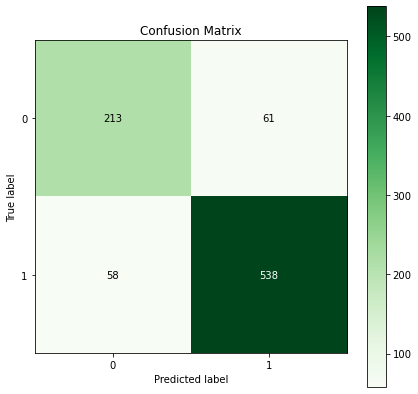

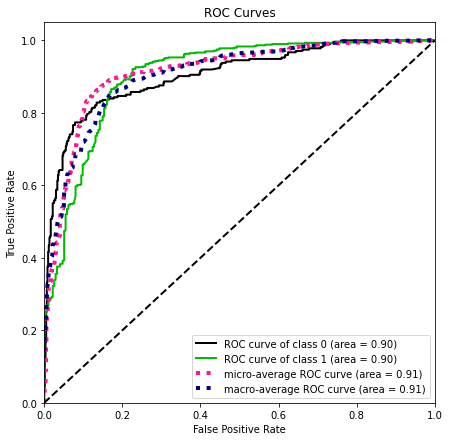

In [44]:
%%time
modelo = MultinomialNB()

param_grid = {
    'alpha': [0.001, 0.005, 0.1, 0.5, 1.0]
}

classificador = RandomizedSearchCV(modelo, 
                               param_distributions=param_grid, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               cv=5, 
                               refit=True,
                               random_state=42)

search_nb  = classificador.fit(X_over, y_over)
ypred_nb   = classificador.predict(X_over)
y_pred     = classificador.predict(X_test)
y_proba_nb = search_nb.predict_proba(X_test)

# Relatório de desempenho
relatorio_desempenho(y_over, ypred_nb, y_test, y_pred, y_proba_nb)
print(search_nb.best_params_)

======= RELATÓRIO DE DESEMPENHO =======
Apurado nos dados de treino
---------------------------
Acurácia: 84.0701%
F1 score: 84.0488%

Apurado nos dados de teste
----------------------------
Acurácia: 83.908%
F1 score: 84.176%

===== FIM RELATÓRIO DE DESEMPENHO =====
{'solver': 'saga', 'C': 1.0}
CPU times: user 9.13 s, sys: 52.3 ms, total: 9.19 s
Wall time: 56.4 s


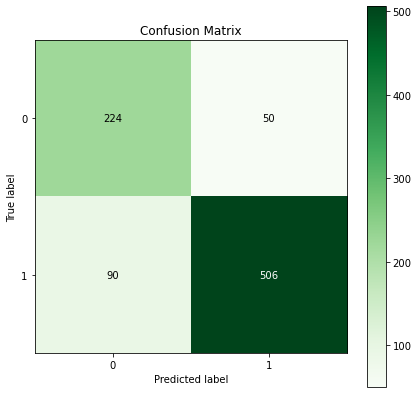

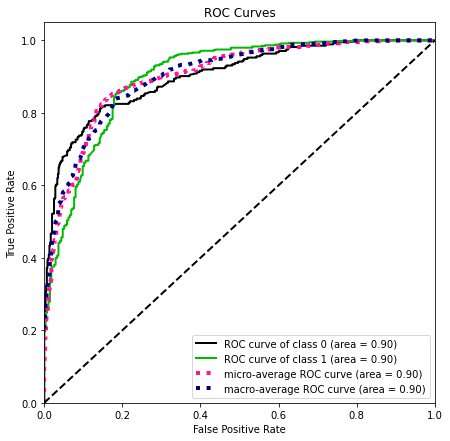

In [45]:
%%time

modelo = LogisticRegression()

param_grid = {
    'solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
    'C': [0.5, 1.0, 2.0, 3.0]
}

classificador = RandomizedSearchCV(modelo, 
                               param_distributions=param_grid, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               cv=5, 
                               refit=True,
                               random_state=42)

search_lr  = classificador.fit(X_over, y_over)
ypred_lr   = classificador.predict(X_over)
y_pred     = classificador.predict(X_test)
y_proba_lr = search_lr.predict_proba(X_test)

# Relatório de desempenho
relatorio_desempenho(y_over, ypred_lr, y_test, y_pred, y_proba_lr)
print(search_lr.best_params_)

/home/angelojr/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/angelojr/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


======= RELATÓRIO DE DESEMPENHO =======
Apurado nos dados de treino
---------------------------
Acurácia: 84.0701%
F1 score: 84.0488%

Apurado nos dados de teste
----------------------------
Acurácia: 80.8046%
F1 score: 80.6958%

===== FIM RELATÓRIO DE DESEMPENHO =====
{'n_estimators': 600, 'criterion': 'gini'}
CPU times: user 1min 47s, sys: 348 ms, total: 1min 47s
Wall time: 15min 13s


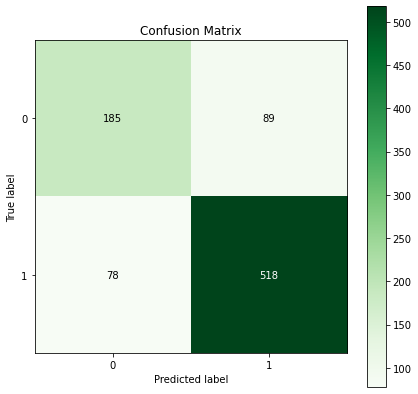

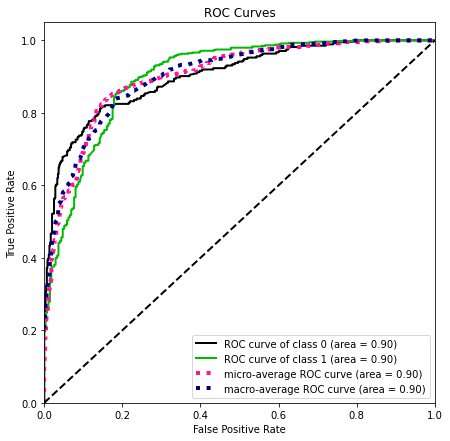

In [46]:
%%time

# esse é com novas features
modelo = RandomForestClassifier()

param_grid = {
    'n_estimators': [400, 600, 800],
    'criterion': ['gini', 'entropy']
}

classificador = RandomizedSearchCV(modelo, 
                               param_distributions=param_grid, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               cv=5, 
                               refit=True,
                               random_state=42)

search_rf  = classificador.fit(X_over, y_over)
ypred_rf   = classificador.predict(X_over)
y_pred     = classificador.predict(X_test)
y_proba_rf = search_lr.predict_proba(X_test)

# Relatório de desempenho
relatorio_desempenho(y_over, ypred_lr, y_test, y_pred, y_proba_rf)
print(search_rf.best_params_)

/home/angelojr/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


======= RELATÓRIO DE DESEMPENHO =======
Apurado nos dados de treino
---------------------------
Acurácia: 84.0701%
F1 score: 84.0488%

Apurado nos dados de teste
----------------------------
Acurácia: 80.8046%
F1 score: 80.6958%

===== FIM RELATÓRIO DE DESEMPENHO =====
{'n_estimators': 800}
CPU times: user 5min 17s, sys: 257 ms, total: 5min 17s
Wall time: 36min 18s


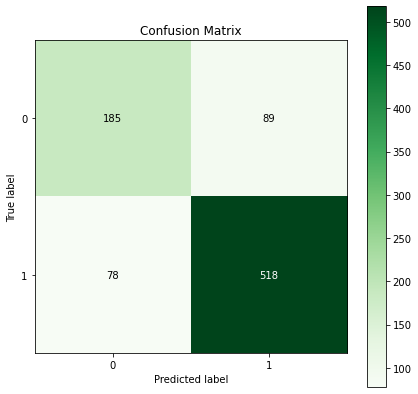

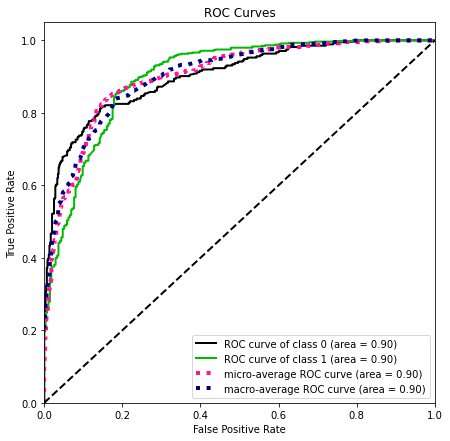

In [47]:
%%time
modelo = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [600, 800]
}

classificador = RandomizedSearchCV(modelo, 
                               param_distributions=param_grid, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               cv=5, 
                               refit=True,
                               random_state=42)

search_gb  = classificador.fit(X_over, y_over)
ypred_gb   = classificador.predict(X_over)
y_proba_gb = search_lr.predict_proba(X_test)

# Relatório de desempenho
relatorio_desempenho(y_over, ypred_lr, y_test, y_pred, y_proba_gb)
print(search_gb.best_params_)

#### 5.2. Criar modelo Deep Learning com Spacy

O Spacy é capaz de processar texto e gerar modelo de deep learning para predição. Para tal, o texto deve estar na forma [resenha, {dicionário com as classes}]. A seguir é feito este préprocessamento, construção e avaliação do modelo.

#### 5.2.1. Criando os dados

In [48]:
# dividir os dados em treino e teste
dados = resenhas_treino[['coment_processado', '5_estrelas']].copy()

y = dados['5_estrelas']
X = dados['coment_processado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [49]:
# colocando os dados em formato resenha-dicionário
ls_treino = []
ls_teste  = []

for texto, class_5 in zip(X_train, y_train):
    if class_5 == 1:
        dic = ({'MENOR_CINCO': False, 'IGUAL_CINCO': True})
    elif class_5 == 0:
        dic = ({'MENOR_CINCO': True, 'IGUAL_CINCO': False})

    ls_treino.append([texto, dic.copy()])
                
# dados de teste
for texto, emocao in zip(X_test, y_test):
    if emocao == 1:
        dic = ({'MENOR_CINCO': False, 'IGUAL_CINCO': True})
    elif emocao == 0:
        dic = ({'MENOR_CINCO': True, 'IGUAL_CINCO': False})

    ls_teste.append([texto, dic.copy()])
    
    
# tamanho:
len(ls_treino), len(ls_teste)

(7828, 870)

In [50]:
# visualizar alguns registros
ls_treino[0:5]

[['umar quase passar prá trás graça app itaú olhar o extrato e ví q o caro tingir cobrar 2x o msm meecadoria .... pedir dinheiro voltar o hr e óbivio devolver né pq falar q devolver iriar acionar o .... caro safar pouting_face pouting_face pouting_face pouting_face pouting_face pouting_face pouting_face obg itaú',
  {'MENOR_CINCO': False, 'IGUAL_CINCO': True}],
 ['o app er otimo e o servisso tabem so o limitar cartão crédito qui e baixar',
  {'MENOR_CINCO': True, 'IGUAL_CINCO': False}],
 ['ótimo app simples e super intuitivo parabém desenvolvedores',
  {'MENOR_CINCO': False, 'IGUAL_CINCO': True}],
 ['útil', {'MENOR_CINCO': False, 'IGUAL_CINCO': True}],
 ['melhor cartão', {'MENOR_CINCO': False, 'IGUAL_CINCO': True}]]

#### 5.2.2. Criando o classificador

In [51]:
# cria o modelo em branco
modelo = spacy.blank('pt')

# criação das classes
categorias = modelo.create_pipe("textcat") # constante: textcat
categorias.add_label("IGUAL_CINCO")
categorias.add_label("MENOR_CINCO")
modelo.add_pipe(categorias)
historico = []

In [52]:
%%time
# instancia o modelo de deep learning do spaCy
modelo.begin_training()

for epoca in range(20): # serão usadas 20 épocas
    random.shuffle(ls_treino)
    losses = {}

    for batch in spacy.util.minibatch(ls_treino, 512): # atualiza a loss a cada 512 registros
        textos = [modelo(texto) for texto, entities in batch]
        annotations = [{'cats': entities} for texto, entities in batch]
        modelo.update(textos, annotations, losses=losses)
        historico.append(losses)
        
    if epoca % 4 == 0:
        print(losses)

{'textcat': 3.360765435900248e-05}
{'textcat': 1.4383181621724361e-05}
{'textcat': 1.1221555723750498e-05}
{'textcat': 1.080457940361157e-05}
{'textcat': 1.1157141159401363e-05}
CPU times: user 8min 52s, sys: 6.6 s, total: 8min 58s
Wall time: 5min 14s


In [53]:
# armazenar o histórico na loss function em uma lista
historico_loss = []

for i in historico:
    historico_loss.append(i.get('textcat'))

In [54]:
# transformar a lista do histórico da loss function em array do Numpy
historico_loss = np.array(historico_loss)
historico_loss[0]

3.360765435900248e-05

Text(0, 0.5, 'Erro')

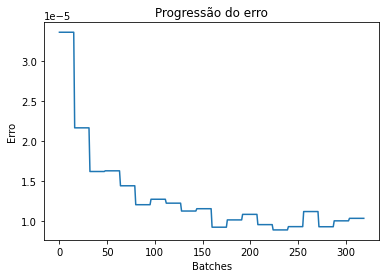

In [55]:
# visualizar o comportamento da loss function
import matplotlib.pyplot as plt

plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

#### 5.2.3. Avaliação dos resultados

In [56]:
# gerando as previsões
prev_treino = []
prev_teste  = []

for texto in X_train:
    previsao = modelo(texto)
    prev_treino.append(previsao.cats)
    
for texto in X_test:
    previsao = modelo(texto)
    prev_teste.append(previsao.cats)

In [57]:
# criar previsões em formato binário
prev_treino_binario = []
prev_teste_binario  = []

for previsao in prev_treino:
    if previsao['IGUAL_CINCO'] > previsao['MENOR_CINCO']:
        prev_treino_binario.append(1)
    else:
        prev_treino_binario.append(0)
        
for previsao in prev_teste:
    if previsao['IGUAL_CINCO'] > previsao['MENOR_CINCO']:
        prev_teste_binario.append(1)
    else:
        prev_teste_binario.append(0)

# transforma a lista em array do Numpy
prev_treino_binario = np.array(prev_treino_binario)
prev_teste_binario  = np.array(prev_teste_binario)

In [58]:
# criar a previsão em formato de probabilidades
prev_teste_proba = []

for previsao in prev_teste:
    prev_teste_proba.append([
        round(previsao['MENOR_CINCO'], 8), 
        round(previsao['IGUAL_CINCO'], 8)])

prev_teste_proba = np.array(prev_teste_proba)

======= RELATÓRIO DE DESEMPENHO =======
Apurado nos dados de treino
---------------------------
Acurácia: 94.277%
F1 score: 94.1404%

Apurado nos dados de teste
----------------------------
Acurácia: 83.6782%
F1 score: 83.5224%

===== FIM RELATÓRIO DE DESEMPENHO =====


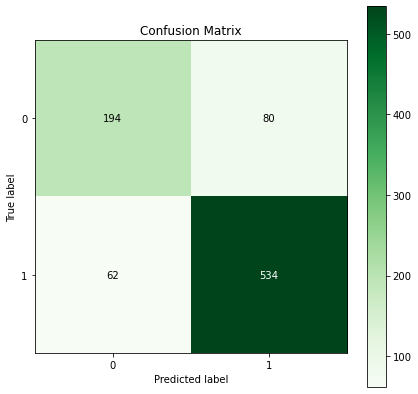

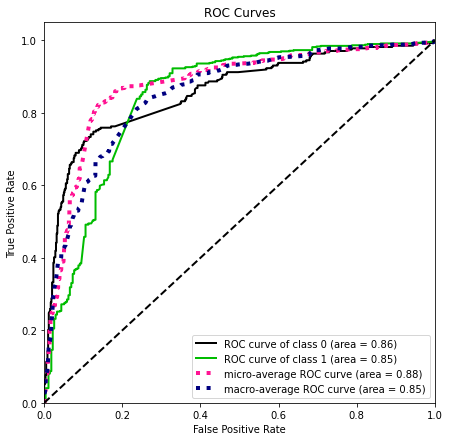

In [59]:
relatorio_desempenho(y_train, prev_treino_binario, y_test, prev_teste_binario, prev_teste_proba)

### 6. Acurácia no conjunto de dados de validação (acurácia final)
Será utilizado o modelo Multinomial Naive Bayes por ter tido melhor performance sobre os dados de teste, observando o F1 Score, Curva ROC e Acurácia.

In [60]:
# Criar matriz esparsa a partir do vetorizador nos dados de validação
X = vect.transform(resenhas_validacao.coment_processado)

# Gerar Pandas DataFrame para os dados de validação
resenhas_tfidf = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
resenhas_tfidf.head()

,00,abertura,abrir,abrir aplicativo,abrir app,abrir contar,abrir umar,absurdo,acabar,aceitar,aceito,acessar,acessar app,acessar contar,acesso,acesso contar,achar,acontecer,adiantar,adorar,agenciar,agência,ai,ajudar,algum,alguém,alto,amar,android,ano,antar,antigo,anuidade,aparecer,aparecer umar,aparelhar,aplicativo,aplicativo ajudar,aplicativo banco,aplicativo bom,aplicativo caixa,aplicativo conseguir,aplicativo ficar,aplicativo funcionar,aplicativo fácil,aplicativo ótimo,app,app ajudar,app banco,app bom,app caixa,app conseguir,app excelente,app ficar,app funcionar,app itaú,app melhor,app nao,app parir,app pra,app prático,app ótimo,apps,apresentar,aprovar,arrumar,assinatura,atar,atender,atendimento,ater,ater expectativa,ater necessidade,ativar,atualiza,atualizar,atualização,atualizei,aumentar,aumentar limitar,autorizar,avaliar,baixar,baixar app,banco,banco brasil,banco digital,banco itaú,banco parir,bancário,barrir,biometria,bloquear,bolar,boletar,boleto,bom,bom ajudar,bom aplicativo,bom app,bom atendimento,bom ater,bom bom,bom conseguir,bom demais,bom facilitar,bom fácil,bom gostar,bom melhor,bom noite,bom parabém,bom pra,bom praticar,bom prático,bom recomendar,bom ótimo,bradesco,brasil,bug,burocracia,buscar,cadastrar,cadastrar senha,cair,caixa,caixa econômica,caixa eletrônico,cancelar,caro,carregar,cartao,cartão,cartão chegar,cartão crédito,cartão débito,casar,celular,central,certar,certo,chat,chato,chave,chave segurança,chegar,cincar,clicar,cliente,cobrar,code,colocar,colocar senha,comer,começar,comodidade,completar,complicar,comprar,comprovante,conectar,conexão,confiável,confuso,conhecer,conseguir,conseguir abrir,conseguir acessar,conseguir acesso,conseguir cadastrar,conseguir entrar,conseguir pagar,conseguir realizar,conseguir resolver,consultar,consulto,contar,contar app,contar banco,contar conseguir,contar pelar,contar poupança,contar salário,contato,continuar,corrigir,cpf,creditar,criar,crédito,cumprir,código,código barrir,datar,datar nascimento,debitar,decepcionar,deixar,deixar desejar,demais,demorar,demorar parir,depositar,depósito,desbloquear,desbloquear cartão,descontar,desejar,desenvolvedores,desinstalar,desinstalei,dessar,detalhar,deus,dever,dia,dia dia,diferente,dificuldade,difícil,digital,digitar,digitar senha,dinheiro,direito,direto,disponível,dispositivo,documentar,débito,dígito,dúvida,econômica,efetuar,eficaz,eficiente,eletrônica,eletrônico,email,empresar,empréstimo,encontrar,entender,entrar,entrar app,entrar contar,enviar,equipar,errar,escolher,esperar,esquecer,estrelo,etc,ex,excelente,excelente aplicativo,excelente app,excelente banco,excelente ótimo,excluir,exelente,existir,expectativa,experiência,extrato,facil,facilidade,facilitar,facilitar dia,facilitar vidar,falar,falho,falir,faltar,falto,fatura,fatura cartão,faturas,fechar,feliz,fgts,ficar,ficar melhor,filar,finalizar,financeiro,folded_hands,formar,foto,funcional,funcionalidade,funcionar,funcionar perfeitamente,função,fácil,fácil acesso,fácil manusear,fácil prático,fácil rápido,físico,gastar,gente,gerar,gerente,gostar,gostar aplicativo,gostar app,gostar dessar,haver,hj,hoje,horar,horrível,horário,igual,importante,impossível,incrível,indicar,indisponível,infelizmente,informar,informação,inicial,instalar,internet,intuitivo,investimento,inválido,itau,itaú,itoken,ja,jeito,jeito nenhum,jogar,juro,legal,leitor,lentar,ler,levar,liberar,ligar,light_skin_tone,limitar,lixar,lo,logar,login,mail,mandar,manusear,maravilhoso,mau,mear,medium,medium light_skin_tone,melhor,melhor aplicativo,melhor app,melhor banco,melhor cartão,melhorar,mensagem,mercar,mexer,mim,mostrar,movimentar,movimentação,msm,mt,mt bom,mto,mudar,mundo,mão,nado,nao,nao conseguir,nao funcionar,nascimento,necessidade,necessário,nenhum,nenhum problema,noite,nome,normal,noto,novamente,nu,nubank,nuconta,numerar,nó,obrigar,oferecer,ok,olhar,olá,online,operação,opinião,opção,opção parir,oq,otima,otimo,otimo aplicativo,otimo app,outro,outro banco,pagamento,pagamento transferência,pagar,pagar contar,pago,pa

In [61]:
%%time

# criar novas variáeis
resenhas_validacao['qtde_palavras']    = resenhas_validacao['Comentario'].apply(qtde_palavras)
resenhas_validacao['qtde_maiusculas']  = resenhas_validacao['Comentario'].apply(qtde_maiusculas)
resenhas_validacao['comprimento']      = resenhas_validacao['Comentario'].apply(comprimento)
resenhas_validacao['maiusc_x_compri']  = resenhas_validacao['qtde_maiusculas'] / resenhas_validacao['comprimento']
resenhas_validacao['qtde_exclamacoes'] = resenhas_validacao['Comentario'].apply(qtde_exclamacoes)
resenhas_validacao['qtde_interrogacoes'] = resenhas_validacao['Comentario'].apply(qtde_interrogacoes)
resenhas_validacao['qtde_pontuacoes']    = resenhas_validacao['Comentario'].apply(qtde_pontuacoes)
resenhas_validacao['qtde_simbolos']      = resenhas_validacao['Comentario'].apply(qtde_simbolos)
resenhas_validacao['qtde_palavras_unicas'] = resenhas_validacao['Comentario'].apply(qtde_palavras_unicas)
resenhas_validacao['unicas_x_comprimento'] = resenhas_validacao['qtde_palavras_unicas'] / resenhas_validacao['comprimento']
resenhas_validacao['qtde_substantivos'], resenhas_validacao['qtde_adjetivos'], resenhas_validacao['qtde_verbos'], resenhas_validacao['qtde_adverbios'], resenhas_validacao['qtde_interjeicoes'] = zip(*resenhas_validacao['Comentario'].apply(lambda comment: qtde_tag_part_of_speech(comment)))

resenhas_validacao['substantivos_vs_comprimento']  = resenhas_validacao['qtde_substantivos'] / resenhas_validacao['comprimento']
resenhas_validacao['adjectivos_x_comprimento']     = resenhas_validacao['qtde_adjetivos'] / resenhas_validacao['comprimento']
resenhas_validacao['verbos_x_comprimento']         = resenhas_validacao['qtde_verbos'] /resenhas_validacao['comprimento']
resenhas_validacao['adverbios_x_comprimento']      = resenhas_validacao['qtde_adverbios'] /resenhas_validacao['comprimento']
resenhas_validacao['interjeicoes_x_comprimento']   = resenhas_validacao['qtde_interjeicoes'] /resenhas_validacao['comprimento']
resenhas_validacao['substantivos_x_qtde_palavras'] = resenhas_validacao['qtde_substantivos'] / resenhas_validacao['qtde_palavras']
resenhas_validacao['adjectivos_x_qtde_palavras']   = resenhas_validacao['qtde_adjetivos'] / resenhas_validacao['qtde_palavras']
resenhas_validacao['verbos_x_qtde_palavras']       = resenhas_validacao['qtde_verbos'] / resenhas_validacao['qtde_palavras']
resenhas_validacao['adverbios_x_qtde_palavras']    = resenhas_validacao['qtde_adverbios'] / resenhas_validacao['qtde_palavras']
resenhas_validacao['interjeicoes_x_qtde_palavras'] = resenhas_validacao['qtde_interjeicoes'] / resenhas_validacao['qtde_palavras']

CPU times: user 9.16 s, sys: 20 ms, total: 9.18 s
Wall time: 9.18 s


In [62]:
# incluir novas variáveis no cojunto de dados tfidf

resenhas_tfidf['qtde_palavras']                = resenhas_validacao['qtde_palavras']                 
resenhas_tfidf['qtde_maiusculas']              = resenhas_validacao['qtde_maiusculas']               
resenhas_tfidf['comprimento']                  = resenhas_validacao['comprimento']                   
resenhas_tfidf['maiusc_x_compri']              = resenhas_validacao['maiusc_x_compri']               
resenhas_tfidf['qtde_exclamacoes']             = resenhas_validacao['qtde_exclamacoes']              
resenhas_tfidf['qtde_interrogacoes']           = resenhas_validacao['qtde_interrogacoes']            
resenhas_tfidf['qtde_pontuacoes']              = resenhas_validacao['qtde_pontuacoes']               
resenhas_tfidf['qtde_simbolos']                = resenhas_validacao['qtde_simbolos']                 
resenhas_tfidf['qtde_palavras_unicas']         = resenhas_validacao['qtde_palavras_unicas']          
resenhas_tfidf['unicas_x_comprimento']         = resenhas_validacao['unicas_x_comprimento']          
resenhas_tfidf['qtde_substantivos']            = resenhas_validacao['qtde_substantivos']                         
resenhas_tfidf['qtde_adjetivos']               = resenhas_validacao['qtde_adjetivos']                    
resenhas_tfidf['qtde_verbos']                  = resenhas_validacao['qtde_verbos']                         
resenhas_tfidf['qtde_adverbios']               = resenhas_validacao['qtde_adverbios']              
resenhas_tfidf['qtde_interjeicoes']            = resenhas_validacao['qtde_interjeicoes']              
resenhas_tfidf['substantivos_vs_comprimento']  = resenhas_validacao['substantivos_vs_comprimento']   
resenhas_tfidf['adjectivos_x_comprimento']     = resenhas_validacao['adjectivos_x_comprimento']      
resenhas_tfidf['verbos_x_comprimento']         = resenhas_validacao['verbos_x_comprimento']          
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_validacao['adverbios_x_comprimento']
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_validacao['interjeicoes_x_comprimento']
resenhas_tfidf['substantivos_x_qtde_palavras'] = resenhas_validacao['substantivos_x_qtde_palavras']  
resenhas_tfidf['adjectivos_x_qtde_palavras']   = resenhas_validacao['adjectivos_x_qtde_palavras']    
resenhas_tfidf['verbos_x_qtde_palavras']       = resenhas_validacao['verbos_x_qtde_palavras']       
resenhas_tfidf['adverbios_x_qtde_palavras']    = resenhas_validacao['adverbios_x_qtde_palavras']
resenhas_tfidf['interjeicoes_x_qtde_palavras'] = resenhas_validacao['interjeicoes_x_qtde_palavras']

In [63]:
# colocar os dados na mesma escala
validacao = scaler.transform(resenhas_tfidf.fillna(0))

In [64]:
# Fazer a predição
y_pred_binario = search_nb.predict(validacao)
y_pred_proba   = search_nb.predict_proba(validacao)

In [65]:
# função para gerar relatório de desempenho final
def relatorio_desempenho_final(y_true_teste, y_prev_teste, y_proba_teste):
    print('======= RELATÓRIO DE DESEMPENHO FINAL =======')  
    print('---------------------------------------------')
    acuracia = round(accuracy_score(y_true_teste, y_prev_teste) * 100, 4)
    f1       = round(f1_score(y_true_teste, y_prev_teste, average='weighted') * 100, 4)
    print('Acurácia: {}%'.format(acuracia))
    print('F1 score: {}%'.format(f1))

    # Matriz de confusão
    skplt.metrics.plot_confusion_matrix(y_true_teste, y_prev_teste, figsize=(7,7), cmap='Greens')
    
    # 'Curva ROC nos dados de teste'
    skplt.metrics.plot_roc(y_true_teste, y_proba_teste, figsize=(7,7))
    print('\n===== FIM RELATÓRIO DE DESEMPENHO FINAL =====')

======= RELATÓRIO DE DESEMPENHO FINAL =======
---------------------------------------------
Acurácia: 84.3636%
F1 score: 84.3586%

===== FIM RELATÓRIO DE DESEMPENHO FINAL =====


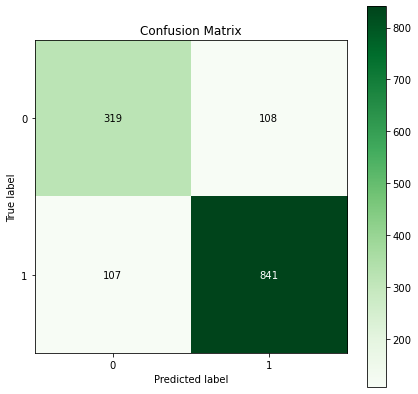

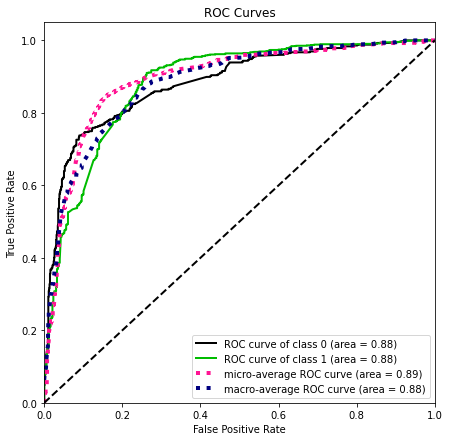

In [66]:
relatorio_desempenho_final(resenhas_validacao['5_estrelas'], y_pred_binario, y_pred_proba)

### 7. Gerar artefatos para deploy

#### 7.1. Retreinar o modelo sobre todo o conjunto de dados

In [67]:
# vetorizador
vect = TfidfVectorizer(stop_words=ls_stop_words, # define as stop-words
                       ngram_range=(1, 2),       # gerar unigramas e bigramas
                       max_features=600          # selecionar as 600 features (variáveis) mais importantes
                      ).fit(resenhas_treino.coment_processado)

In [68]:
# Criar matriz esparsa a partir do vetorizador
X = vect.transform(resenhas_treino.coment_processado)

In [69]:
# Gerar Pandas DataFrame
resenhas_tfidf = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

In [70]:
# anexar os dados
resenhas_tfidf['qtde_palavras']                = resenhas_treino['qtde_palavras']                 
resenhas_tfidf['qtde_maiusculas']              = resenhas_treino['qtde_maiusculas']               
resenhas_tfidf['comprimento']                  = resenhas_treino['comprimento']                   
resenhas_tfidf['maiusc_x_compri']              = resenhas_treino['maiusc_x_compri']               
resenhas_tfidf['qtde_exclamacoes']             = resenhas_treino['qtde_exclamacoes']              
resenhas_tfidf['qtde_interrogacoes']           = resenhas_treino['qtde_interrogacoes']            
resenhas_tfidf['qtde_pontuacoes']              = resenhas_treino['qtde_pontuacoes']               
resenhas_tfidf['qtde_simbolos']                = resenhas_treino['qtde_simbolos']                 
resenhas_tfidf['qtde_palavras_unicas']         = resenhas_treino['qtde_palavras_unicas']          
resenhas_tfidf['unicas_x_comprimento']         = resenhas_treino['unicas_x_comprimento']          
resenhas_tfidf['qtde_substantivos']            = resenhas_treino['qtde_substantivos']                         
resenhas_tfidf['qtde_adjetivos']               = resenhas_treino['qtde_adjetivos']                    
resenhas_tfidf['qtde_verbos']                  = resenhas_treino['qtde_verbos']                         
resenhas_tfidf['qtde_adverbios']               = resenhas_treino['qtde_adverbios']              
resenhas_tfidf['qtde_interjeicoes']            = resenhas_treino['qtde_interjeicoes']              
resenhas_tfidf['substantivos_vs_comprimento']  = resenhas_treino['substantivos_vs_comprimento']   
resenhas_tfidf['adjectivos_x_comprimento']     = resenhas_treino['adjectivos_x_comprimento']      
resenhas_tfidf['verbos_x_comprimento']         = resenhas_treino['verbos_x_comprimento']          
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_treino['adverbios_x_comprimento']
resenhas_tfidf['interjeicoes_x_comprimento']   = resenhas_treino['interjeicoes_x_comprimento']
resenhas_tfidf['substantivos_x_qtde_palavras'] = resenhas_treino['substantivos_x_qtde_palavras']  
resenhas_tfidf['adjectivos_x_qtde_palavras']   = resenhas_treino['adjectivos_x_qtde_palavras']    
resenhas_tfidf['verbos_x_qtde_palavras']       = resenhas_treino['verbos_x_qtde_palavras']       
resenhas_tfidf['adverbios_x_qtde_palavras']    = resenhas_treino['adverbios_x_qtde_palavras']
resenhas_tfidf['interjeicoes_x_qtde_palavras'] = resenhas_treino['interjeicoes_x_qtde_palavras']

In [71]:
# aplicar normalizador e oversample
X = scaler.transform(resenhas_tfidf.fillna(0))
y = resenhas_treino['5_estrelas']

oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

In [72]:
# treinar o modelo
modelo = MultinomialNB(alpha=0.001)
modelo.fit(X_over, y_over)

MultinomialNB(alpha=0.001)

In [73]:
# Fazer a predição
y_pred_binario = search_gb.predict(validacao)
y_pred_proba   = search_gb.predict_proba(validacao)

======= RELATÓRIO DE DESEMPENHO FINAL =======
---------------------------------------------
Acurácia: 83.8545%
F1 score: 83.7566%

===== FIM RELATÓRIO DE DESEMPENHO FINAL =====


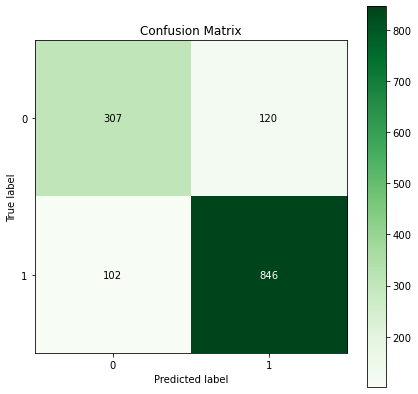

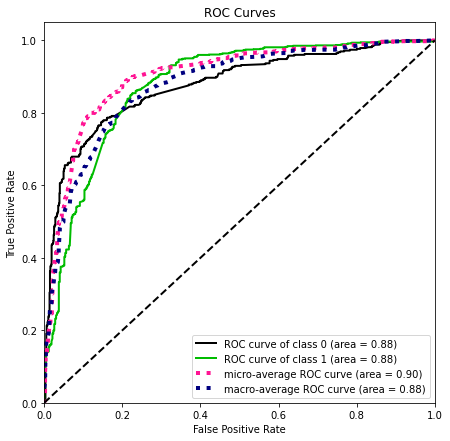

In [74]:
# checar o resultado
relatorio_desempenho_final(resenhas_validacao['5_estrelas'], y_pred_binario, y_pred_proba)

#### 7.2. Armazenar os artefatos em disco

In [75]:
# vetorizadr tf-idf
pickle.dump(vect, open('vect_estrelas.pkl', 'wb'))

# min max scaler
pickle.dump(scaler, open('scaler_estrelas.pkl', 'wb'))

# modelo
pickle.dump(modelo, open('naive_bayes.pkl', 'wb'))

### 8. Teste com 1 resenha isolada

#### 8.1. Apresenhar resenha e exibir entidades e dependências

In [76]:
# Resenha recuperada na Google Play em 17/09/2020 para o app da Caixa Econômica Federal
# foi atribuído 2 estrelas
resenha = 'Muito complicado! Até para pagar contas ele lê o código de barras errado.'

In [77]:
# processar o texto com Spacy
documento = pln(resenha)

In [78]:
# Exibir entidades da resenha
from spacy import displacy
displacy.render(documento, style = 'ent', jupyter = True)

/home/angelojr/anaconda3/lib/python3.8/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [79]:
# Exibir dependências
displacy.render(documento, style='dep', jupyter=True, options={'distance': 90})

#### 8.2. Tratar a resenha para o modelo

In [80]:
d = {'Comentario': [resenha]}
resenha_df = pd.DataFrame(data=d)
resenha_df.head()

,Comentario
0,Muito complicado! Até para pagar contas ele lê...


In [81]:
# aplicar a função de préprocessamento
resenha_df['coment_processado'] = resenha_df['Comentario'].apply(preprocessamento)

In [82]:
# vetorizar os dados
X = vect.transform(resenha_df.coment_processado)

In [83]:
# Gerar Pandas DataFrame
resenhas_tfidf = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

In [84]:
# criar novas variáeis
resenha_df['qtde_palavras']    = resenha_df['Comentario'].apply(qtde_palavras)
resenha_df['qtde_maiusculas']  = resenha_df['Comentario'].apply(qtde_maiusculas)
resenha_df['comprimento']      = resenha_df['Comentario'].apply(comprimento)
resenha_df['maiusc_x_compri']  = resenha_df['qtde_maiusculas'] / resenha_df['comprimento']
resenha_df['qtde_exclamacoes'] = resenha_df['Comentario'].apply(qtde_exclamacoes)
resenha_df['qtde_interrogacoes'] = resenha_df['Comentario'].apply(qtde_interrogacoes)
resenha_df['qtde_pontuacoes']    = resenha_df['Comentario'].apply(qtde_pontuacoes)
resenha_df['qtde_simbolos']      = resenha_df['Comentario'].apply(qtde_simbolos)
resenha_df['qtde_palavras_unicas'] = resenha_df['Comentario'].apply(qtde_palavras_unicas)
resenha_df['unicas_x_comprimento'] = resenha_df['qtde_palavras_unicas'] / resenha_df['comprimento']
resenha_df['qtde_substantivos'], resenha_df['qtde_adjetivos'], resenha_df['qtde_verbos'], resenha_df['qtde_adverbios'], resenha_df['qtde_interjeicoes'] = zip(*resenha_df['Comentario'].apply(lambda comment: qtde_tag_part_of_speech(comment)))

resenha_df['substantivos_vs_comprimento']  = resenha_df['qtde_substantivos'] / resenha_df['comprimento']
resenha_df['adjectivos_x_comprimento']     = resenha_df['qtde_adjetivos'] / resenha_df['comprimento']
resenha_df['verbos_x_comprimento']         = resenha_df['qtde_verbos'] /resenha_df['comprimento']
resenha_df['adverbios_x_comprimento']      = resenha_df['qtde_adverbios'] /resenha_df['comprimento']
resenha_df['interjeicoes_x_comprimento']   = resenha_df['qtde_interjeicoes'] /resenha_df['comprimento']
resenha_df['substantivos_x_qtde_palavras'] = resenha_df['qtde_substantivos'] / resenha_df['qtde_palavras']
resenha_df['adjectivos_x_qtde_palavras']   = resenha_df['qtde_adjetivos'] / resenha_df['qtde_palavras']
resenha_df['verbos_x_qtde_palavras']       = resenha_df['qtde_verbos'] / resenha_df['qtde_palavras']
resenha_df['adverbios_x_qtde_palavras']    = resenha_df['qtde_adverbios'] / resenha_df['qtde_palavras']
resenha_df['interjeicoes_x_qtde_palavras'] = resenha_df['qtde_interjeicoes'] / resenha_df['qtde_palavras']

In [85]:
# anexar os dados
resenhas_tfidf['qtde_palavras']                = resenha_df['qtde_palavras']                 
resenhas_tfidf['qtde_maiusculas']              = resenha_df['qtde_maiusculas']               
resenhas_tfidf['comprimento']                  = resenha_df['comprimento']                   
resenhas_tfidf['maiusc_x_compri']              = resenha_df['maiusc_x_compri']               
resenhas_tfidf['qtde_exclamacoes']             = resenha_df['qtde_exclamacoes']              
resenhas_tfidf['qtde_interrogacoes']           = resenha_df['qtde_interrogacoes']            
resenhas_tfidf['qtde_pontuacoes']              = resenha_df['qtde_pontuacoes']               
resenhas_tfidf['qtde_simbolos']                = resenha_df['qtde_simbolos']                 
resenhas_tfidf['qtde_palavras_unicas']         = resenha_df['qtde_palavras_unicas']          
resenhas_tfidf['unicas_x_comprimento']         = resenha_df['unicas_x_comprimento']          
resenhas_tfidf['qtde_substantivos']            = resenha_df['qtde_substantivos']                         
resenhas_tfidf['qtde_adjetivos']               = resenha_df['qtde_adjetivos']                    
resenhas_tfidf['qtde_verbos']                  = resenha_df['qtde_verbos']                         
resenhas_tfidf['qtde_adverbios']               = resenha_df['qtde_adverbios']              
resenhas_tfidf['qtde_interjeicoes']            = resenha_df['qtde_interjeicoes']              
resenhas_tfidf['substantivos_vs_comprimento']  = resenha_df['substantivos_vs_comprimento']   
resenhas_tfidf['adjectivos_x_comprimento']     = resenha_df['adjectivos_x_comprimento']      
resenhas_tfidf['verbos_x_comprimento']         = resenha_df['verbos_x_comprimento']          
resenhas_tfidf['interjeicoes_x_comprimento']   = resenha_df['adverbios_x_comprimento']
resenhas_tfidf['interjeicoes_x_comprimento']   = resenha_df['interjeicoes_x_comprimento']
resenhas_tfidf['substantivos_x_qtde_palavras'] = resenha_df['substantivos_x_qtde_palavras']  
resenhas_tfidf['adjectivos_x_qtde_palavras']   = resenha_df['adjectivos_x_qtde_palavras']    
resenhas_tfidf['verbos_x_qtde_palavras']       = resenha_df['verbos_x_qtde_palavras']       
resenhas_tfidf['adverbios_x_qtde_palavras']    = resenha_df['adverbios_x_qtde_palavras']
resenhas_tfidf['interjeicoes_x_qtde_palavras'] = resenha_df['interjeicoes_x_qtde_palavras']

In [86]:
# normalizar os dados
X = scaler.transform(resenhas_tfidf.fillna(0))

In [87]:
# probabilidade de ser 5 estrelas
round(search_gb.predict_proba(X)[0][1], 4) * 100

15.260000000000002

# FIM